# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [1]:
%pip install -qU ragas==0.2.10

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

ERROR: Ignored the following yanked versions: 0.8.3, 0.10.19.dev18
ERROR: Could not find a version that satisfies the requirement unstructured==0.16.12 (from versions: 0.0.1.dev0, 0.2.0, 0.2.1, 0.2.2, 0.2.3, 0.2.4, 0.2.5, 0.2.6.dev1, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 0.3.4, 0.3.5, 0.4.0, 0.4.1, 0.4.2, 0.4.3, 0.4.4, 0.4.6, 0.4.7, 0.4.8, 0.4.9, 0.4.10, 0.4.11, 0.4.12, 0.4.13, 0.4.14, 0.4.15, 0.4.16, 0.5.0, 0.5.1, 0.5.2, 0.5.3, 0.5.4, 0.5.6, 0.5.7, 0.5.8, 0.5.9, 0.5.10, 0.5.11, 0.5.12, 0.5.13, 0.6.0, 0.6.1, 0.6.2, 0.6.3, 0.6.4, 0.6.5, 0.6.6, 0.6.7, 0.6.8, 0.6.9, 0.6.10, 0.6.11, 0.7.0, 0.7.1, 0.7.2, 0.7.3, 0.7.4, 0.7.5, 0.7.6, 0.7.7, 0.7.8, 0.7.9, 0.7.10, 0.7.11, 0.7.12, 0.8.0, 0.8.1, 0.8.4, 0.8.5, 0.8.6, 0.8.7, 0.8.8, 0.9.0, 0.9.1, 0.9.2, 0.9.3, 0.10.0, 0.10.1, 0.10.2, 0.10.4, 0.10.5, 0.10.6, 0.10.7, 0.10.8, 0.10.9, 0.10.10, 0.10.11, 0.10.12, 0.10.13, 0.10.14, 0.10.15, 0.10.16, 0.10.18, 0.10.19, 0.10.20, 0.10.21, 0.10.22, 0.10.23, 0.10.24, 0.10.25, 0.10.26, 0.10.27, 0.10.28, 0.10.29, 0.10.30, 0

In [1]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [2]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [4]:
!mkdir data

mkdir: data: File exists


In [5]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31314    0 31314    0     0  94392      0 --:--:-- --:--:-- --:--:-- 94604


In [6]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70173    0 70173    0     0   780k      0 --:--:-- --:--:-- --:--:--  787k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [4]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.


### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [5]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

/Users/anupama/Projects/ai_maker_space/AIE5_BD/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [6]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [7]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 2, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [8]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

KnowledgeGraph(nodes: 14, relationships: 70)

We can save and load our knowledge graphs as follows.

In [9]:
kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")
ai_across_years_kg

KnowledgeGraph(nodes: 14, relationships: 70)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [10]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [11]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.

SingleHopSpecificQuerySynthesizer (50%)

    It is the most basic type of query synthesizer which focuses on straight forward query based on facts, involving single reasoning step, for ex:
    Who is the President of ABC Corp. If such a direct fact is mentioned in the document. (single Step/hop)
 

MultiHopAbstractQuerySynthesizer (25%)

    This usually requires multi-step reasoning, What is the country of birth for the president of the ABC Corp, -> this can be loosely broken down into two distinct questions, who is the president of ABC Corp--> Then {answer's} country (requires multi hop)


MultiHopSpecificQuerySynthesizer
    
    Similar to the MultiHopAbstract , but focuses on specific, detailed queries rather than general ones.
    The queries explicitly connect multiple pieces of information in a structured manner.
    Example: Instead of asking "Who was the Prime Minister of the country which president of the ABC Corp belongs to ?", it may generate "Which country was {president} born in, and who was its PM at the time?" in a single, more detailed query.

Finally, we can use our `TestSetGenerator` to generate our testset!

In [12]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating Samples: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]


,user_input,reference_contexts,reference,synthesizer_name
0,What advancements in Large Language Models wer...,[Code may be the best application The ethics o...,"In 2023, it was noted that Large Language Mode...",single_hop_specifc_query_synthesizer
1,What role does achieving AGI play in addressin...,[Based Development As a computer scientist and...,The gullibility of language models is seen as ...,single_hop_specifc_query_synthesizer
2,AI start in 1950s?,[Simon Willison’s Weblog Subscribe Stuff we fi...,The academic field of Artificial Intelligence ...,single_hop_specifc_query_synthesizer
3,What ethical concerns arise from the use of AI...,[easy to follow. The rest of the document incl...,The ethical concerns include whether it is acc...,single_hop_specifc_query_synthesizer
4,"Wut iz Meta's role in the advancement of LLMs,...",[Prompt driven app generation is a commodity a...,Meta is one of the 18 organizations with model...,single_hop_specifc_query_synthesizer
5,How have advancements in prompt-driven app gen...,[<1-hop>\n\nPrompt driven app generation is a ...,Advancements in prompt-driven app generation a...,multi_hop_abstract_query_synthesizer
6,How have advancements in real-time interaction...,[<1-hop>\n\nPrompt driven app generation is a ...,Advancements in real-time interaction have sig...,multi_hop_abstract_query_synthesizer
7,How has the increased competition among AI org...,[<1-hop>\n\nPrompt driven app generation is a ...,The increased competition among AI organizatio...,multi_hop_abstract_query_synthesizer
8,How does the concept of 'Vibes Based Developme...,[<1-hop>\n\nThose of us who understand this st...,The concept of 'Vibes Based Development' relat...,multi_hop_specific_query_synthesizer
9,How does the challenge of evaluating LLMs rela...,[<1-hop>\n\ndependent on AGI itself. A model t...,Evaluating LLMs is challenging due to their co...,multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [13]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Generating Samples: 100%|██████████| 12/12 [00:58<00:00,  4.88s/it]


In [14]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,Wht is Mistral?,[Code may be the best application The ethics o...,Mistral is one of the organizations that have ...,single_hop_specifc_query_synthesizer
1,How do Large Language Models (LLMs) handle Pyt...,[Based Development As a computer scientist and...,"Over the course of the year, it’s become incre...",single_hop_specifc_query_synthesizer
2,What significant developments occurred with La...,[Simon Willison’s Weblog Subscribe Stuff we fi...,2023 was the breakthrough year for Large Langu...,single_hop_specifc_query_synthesizer
3,Wht is ChatGPT?,[easy to follow. The rest of the document incl...,ChatGPT is mentioned in the context as part of...,single_hop_specifc_query_synthesizer
4,How has the concept of universal access to AI ...,[<1-hop>\n\nPrompt driven app generation is a ...,The concept of universal access to AI models s...,multi_hop_abstract_query_synthesizer
5,How has the efficiency and pricing of AI model...,[<1-hop>\n\nPrompt driven app generation is a ...,"In 2024, the efficiency and pricing of AI mode...",multi_hop_abstract_query_synthesizer
6,How has the environmental impact of AI evolved...,[<1-hop>\n\nPrompt driven app generation is a ...,"The environmental impact of AI, particularly w...",multi_hop_abstract_query_synthesizer
7,How has the concept of universal access to AI ...,[<1-hop>\n\nPrompt driven app generation is a ...,"In 2024, the concept of universal access to AI...",multi_hop_abstract_query_synthesizer
8,How does the efficiency and cost-effectiveness...,[<1-hop>\n\ngets you OpenAI’s most expensive m...,GPT-4o is significantly more cost-effective co...,multi_hop_specific_query_synthesizer
9,"How did the advancements in AI, particularly i...",[<1-hop>\n\neasy to follow. The rest of the do...,"In 2023, advancements in AI, especially in Lar...",multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [15]:
from langsmith import Client

client = Client()

dataset_name = "State of AI Across the Years!"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="State of AI Across the Years!"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [16]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [17]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [18]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [19]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [20]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="State of AI"
)

In [21]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [22]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [23]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Finally, we can set-up our RAG LCEL chain!

In [24]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [25]:
rag_chain.invoke({"question" : "What are Agents?"})

'Agents are described as AI systems that can act on your behalf, but the term is extremely vague and lacks a clear, widely understood definition. There are two main categories of thought regarding agents: one sees them as entities that perform tasks like a travel agent, while the other considers them as LLMs (large language models) that can use tools to solve problems. The concept of "autonomy" is also often mentioned in discussions about agents, but it too is not well-defined. Overall, there is skepticism about the current utility of agents due to challenges such as gullibility in AI systems.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4o as our evaluation LLM for our base Evaluators.

In [26]:
eval_llm = ChatOpenAI(model="gpt-4o")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [27]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`: Checks if the response of the LLM caters to the ask in the user {question}
- `labeled_helpfulness_evaluator`: Same as QA, but additionally we are giving LLM a reference context, and it checks how close the response is to the reference output to gauge if the response is helpful or not.
- `dope_or_nope_evaluator`: Checks if the response adhers to an expected style which is "dope"


## LangSmith Evaluation

In [28]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'pertinent-roll-100' at:
https://smith.langchain.com/o/0f68779b-4f33-4cff-b90c-c04c816f8d27/datasets/18dc4bd7-0306-406c-aea7-0df700fce512/compare?selectedSessions=ab431cbb-e47c-4007-bbb4-4086ef2337d1




12it [03:34, 17.88s/it]


,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How did the developments in 2024 regarding GPT...,"In 2024, it became commonplace for individuals...",None,"In 2024, significant progress was made in the ...",1,1,1,6.090491,4845f247-3fa0-4b86-94a8-2e60168bf8b4,5b1d05aa-fb2b-4ce0-972b-134a17a6628a
1,How does Meta's approach to training data for ...,Meta's approach to training data for LLMs refl...,None,"Meta's approach to training data for LLMs, as ...",1,0,1,2.683801,4fc77323-aef9-4f30-9030-4890e8312979,7f231841-d2ab-4aec-8487-58950c85febe
2,"How did the advancements in AI, particularly i...","The advancements in AI, particularly in Large ...",None,"In 2023, advancements in AI, especially in Lar...",1,0,0,3.532327,aa9effdc-eae4-4fdb-9531-0488d76ed845,d622e433-dfce-4c61-9870-d093e845f880
3,How does the efficiency and cost-effectiveness...,The efficiency and cost-effectiveness of GPT-4...,None,GPT-4o is significantly more cost-effective co...,0,0,0,2.570494,631b83d5-2b30-4fff-916b-b73cf3c3cf47,72c95170-dab7-4153-b76d-3a6baf9f3762
4,How has the concept of universal access to AI ...,"In 2024, universal access to the best AI model...",None,"In 2024, the concept of universal access to AI...",1,1,1,4.258505,08fe5cfc-6d42-4da0-a980-160bffcbd429,4a1f9e78-671a-42cb-9bc3-d5fe3a7b8595
5,How has the environmental impact of AI evolved...,The environmental impact of AI has evolved in ...,None,"The environmental impact of AI, particularly w...",1,1,0,3.875196,0dab3b8d-a659-4a5f-a8b3-c9dc13d3ea04,ceb74330-8c2b-4aed-ac5a-ac011963d2b4
6,How has the efficiency and pricing of AI model...,"In 2024, the efficiency of AI models has signi...",None,"In 2024, the efficiency and pricing of AI mode...",1,0,0,4.710065,c7141d10-65ee-40ae-a2c0-68b9102d2093,f90fdb67-3f2c-4d70-868e-1139ba65142b
7,How has the concept of universal access to AI ...,The concept of universal access to AI models h...,None,The concept of universal access to AI models s...,1,1,1,4.092977,216cc3af-b2b4-4b75-8170-960d5a12210e,7c7a7797-26df-4e8b-8d55-cdb79263ba23
8,Wht is ChatGPT?,I don't know.,None,ChatGPT is mentioned in the context as part of...,0,0,0,1.530262,a86b6c88-e3fb-4b09-a012-82bd09795a85,df57f12a-1bf2-441d-a2c8-d41ac4398c56
9,What significant developments occurred with La...,"In 2023, significant developments with Large L...",None,2023 was the breakthrough year for Large Langu...,1,1,1,3.264623,6a539afa-8fc2-45c8-88d0-269b44c14f6e,11800157-ba4d-4582-a738-8b6fdc69f383


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [29]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [30]:
rag_documents = docs

In [31]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

    In my opinion, it is heuristics, its a hyper-parameter in a sense, some application may need bigger chunks , and some smaller. Generally speaking bigger the chunk size, more data that is passed as context for the LLM, this may be useful to tackle long term dependencies, for a complex Q, but on the flip side, increases the noise. 

In [32]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

    A Bigger Embedding Model, with more dimensions would capture more nuances of the text data and present a richer representation, which would in turn help to produce better results, as we rely on cosine similarity which is a spatial similarity metric to determine which chunks should be passed as context to the LLM from the retreiver.

In [33]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Across Years (Augmented)"
)

In [34]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [35]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [36]:
dope_rag_chain.invoke({"question" : "what are Agents?"})

'Yo, Agents are like those mysterious AI systems that folks hope will do stuff for you, kinda like a digital travel agent or assistant. But here\'s the twist: the term is super vague, and it means different things to different people. Some think of them as LLMs using tools to solve problems, while others imagine them as autonomous helpers. But, honestly, they still feel like they\'re "coming soon," and we haven\'t seen many of \'em in action just yet. So, there\'s a lot of hype but not much substance—kinda frustrating, right?'

Finally, we can evaluate the new chain on the same test set!

In [37]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'kind-change-54' at:
https://smith.langchain.com/o/0f68779b-4f33-4cff-b90c-c04c816f8d27/datasets/18dc4bd7-0306-406c-aea7-0df700fce512/compare?selectedSessions=e1f5674d-3a53-47a8-92a3-7af1647408e1




12it [03:25, 17.15s/it]


,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How did the developments in 2024 regarding GPT...,"Yo, in 2024, it was a total game changer! Folk...",None,"In 2024, significant progress was made in the ...",1,1,1,4.158166,4845f247-3fa0-4b86-94a8-2e60168bf8b4,df22db0a-a69f-4bd8-b1e2-8d8869123fd0
1,How does Meta's approach to training data for ...,"Yo, check it! Meta's approach with Llama 3.3 s...",None,"Meta's approach to training data for LLMs, as ...",1,1,1,8.598304,4fc77323-aef9-4f30-9030-4890e8312979,3a866c61-3cac-48e0-bd46-7ac6f80e4221
2,"How did the advancements in AI, particularly i...","Yo, in 2023, we saw some major breakthroughs i...",None,"In 2023, advancements in AI, especially in Lar...",1,0,1,4.407469,aa9effdc-eae4-4fdb-9531-0488d76ed845,a439493b-909d-41ec-a0fb-c1b39eb6f0b4
3,How does the efficiency and cost-effectiveness...,"Yo, check it! GPT-4o is dope at $2.50 per 1,00...",None,GPT-4o is significantly more cost-effective co...,0,0,1,5.121137,631b83d5-2b30-4fff-916b-b73cf3c3cf47,be26ba7d-79fd-4a9c-ab66-bb682c045fba
4,How has the concept of universal access to AI ...,"Yo, the whole scene of universal access to AI ...",None,"In 2024, the concept of universal access to AI...",1,1,1,11.927511,08fe5cfc-6d42-4da0-a980-160bffcbd429,5da9d581-c20c-4b12-a09a-a5d338c07180
5,How has the environmental impact of AI evolved...,"Yo, the environmental impact of AI has had its...",None,"The environmental impact of AI, particularly w...",1,1,1,5.224579,0dab3b8d-a659-4a5f-a8b3-c9dc13d3ea04,0ae5df9e-ea1a-4417-b0a9-8909a5569afb
6,How has the efficiency and pricing of AI model...,"Yo, the landscape of AI models has totally tra...",None,"In 2024, the efficiency and pricing of AI mode...",1,1,1,5.242185,c7141d10-65ee-40ae-a2c0-68b9102d2093,ffdca634-3c93-44ef-9973-25ebf2bd7a79
7,How has the concept of universal access to AI ...,"Yo, check it! The whole vibe of universal acce...",None,The concept of universal access to AI models s...,1,1,1,2.545202,216cc3af-b2b4-4b75-8170-960d5a12210e,2a26c295-8b04-4170-8ba1-3962daba61cf
8,Wht is ChatGPT?,"ChatGPT is like a super slick ""calculator for ...",None,ChatGPT is mentioned in the context as part of...,0,0,1,4.503508,a86b6c88-e3fb-4b09-a012-82bd09795a85,39cbc2cc-3c98-4820-8457-17cf89470c8e
9,What significant developments occurred with La...,"Yo, in 2023, Large Language Models (LLMs) hit ...",None,2023 was the breakthrough year for Large Langu...,1,1,1,3.582366,6a539afa-8fc2-45c8-88d0-269b44c14f6e,f135a64e-fe5c-4cf4-b00e-f172416642a6


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

    The screenshot is attached below,
    There are quite a few reasons:
    1. Changing Chunk size to 1000 would have helped the LLM get more context to answer question, improves QA/helpfulness
    2. Improved Embedding Model would have resulted in a better search for the documents via the retriever, improves QA/helpfulness
    3. Prompt Engineering to add dopeness to the user query instructed the LLM to explicitly add dopeness to its response, improving dopeness

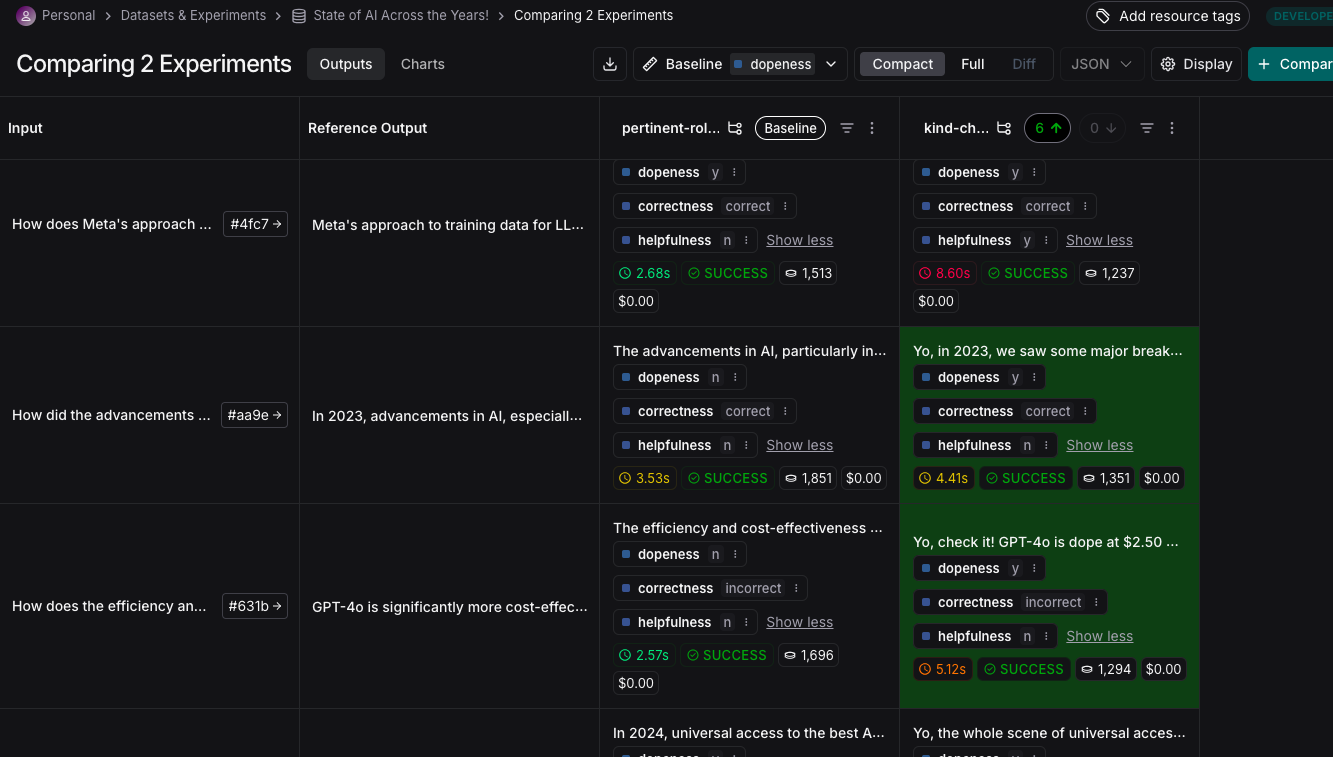

In [38]:
from IPython.display import display, Image
display(Image(filename="/users/anupama/desktop/Screen Shot 2025-02-09 at 9.43.24 PM.png"))